In [76]:
import numpy as np
import pandas as pd
import os
from datetime import date
import sqlalchemy
import pymysql
import re
import matplotlib.pyplot as plt

import warnings    # to avoid warning during executions
warnings.filterwarnings("ignore")

In [3]:
# load all the file names into a list (files in the pbr data folder)
os.getcwd()
_dir_path_day = '../../../dataExport/cumulativeDATA/Day'
_dir_path_hour = '../../../dataExport/cumulativeDATA/Hour'
raw_data_day = os.listdir(_dir_path_day)
raw_data_hour = os.listdir(_dir_path_hour)

In [7]:
raw_data_day

['_10_FPC23_RhoSa.csv',
 '_11_FPC24_SkeMa_1.csv',
 '_12_FPC24_SkeMa_2.csv',
 '_16_FPC23_NaCho.csv',
 '_1_FPC13_ChCal_1.csv',
 '_2_FPC13_ChCal_2.csv',
 '_3_FPC13_ThalaPs.csv',
 '_4_FPC14_ChaMu.csv',
 '_5_FPC14_RhoSa.csv',
 '_6_FPC14_ThalaPs.csv',
 '_7_FPC21_ChaMu.csv',
 '_8_FPC21_TeChu.csv',
 '_9_FPC22_DiaLut.csv']

In [6]:
raw_data_hour

['_10_FPC23_RhoSa.csv',
 '_11_FPC24_SkeMa_1.csv',
 '_12_FPC24_SkeMa_2.csv',
 '_16_FPC23_NaCho.csv',
 '_1_FPC13_ChCal_1.csv',
 '_2_FPC13_ChCal_2.csv',
 '_3_FPC13_ThalaPs.csv',
 '_4_FPC14_ChaMu.csv',
 '_5_FPC14_RhoSa.csv',
 '_6_FPC14_ThalaPs.csv',
 '_7_FPC21_ChaMu.csv',
 '_8_FPC21_TeChu.csv',
 '_9_FPC22_DiaLut.csv']

In [8]:
filename_hour = raw_data_hour[0]
filename_day = raw_data_day[0]

print(filename_hour)
print(filename_day)

_10_FPC23_RhoSa.csv
_10_FPC23_RhoSa.csv


In [9]:
# join file name with path - file name can be specified as list item based on required file name
file_path_day=  os.path.join(_dir_path_day, filename_day)
file_path_hour=  os.path.join(_dir_path_hour, filename_hour)

In [10]:
# load the selected file into the data frame.
sum_Day_raw = pd.read_csv(file_path_day, sep=',')
sum_hour_raw = pd.read_csv(file_path_hour, sep=',')


### Cumulative Hour Data EDA

In [11]:
sum_hour_raw.head(5)

,primary_key,_timeString,unit,D_Algae,D_CD,D_CO2,D_PAR,D_eff,D_feed,D_g,D_harvest
0,1616425200,2021-3-22 16:0:0,FPC23,0.0000,-0.1074,0.0000,0.0000,0.0000,0.0000,-0.1895,0.0000
1,1616428800,2021-3-22 17:0:0,FPC23,0.0000,-0.1074,0.0000,0.0000,0.0000,0.0000,-0.1895,0.0000
2,1616432400,2021-3-22 18:0:0,FPC23,0.0000,-0.1074,0.0000,0.0000,0.0000,0.0000,-0.1895,0.0000
3,1616436000,2021-3-22 19:0:0,FPC23,0.0000,-0.1074,0.0000,0.0000,0.0000,0.0000,-0.1895,0.0000
4,1616439600,2021-3-22 20:0:0,FPC23,0.0000,-0.1074,0.0000,0.0000,0.0000,0.0000,-0.1895,0.0000


In [15]:
sum_hour_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2853 entries, 0 to 2852
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   primary_key  2853 non-null   int64 
 1   _timeString  2853 non-null   object
 2   unit         2853 non-null   object
 3   D_Algae      2853 non-null   object
 4   D_CD         2853 non-null   object
 5   D_CO2        2853 non-null   object
 6   D_PAR        2853 non-null   object
 7   D_eff        2804 non-null   object
 8   D_feed       2853 non-null   object
 9   D_g          2804 non-null   object
 10  D_harvest    2853 non-null   object
dtypes: int64(1), object(10)
memory usage: 245.3+ KB


In [16]:
sum_hour_raw.isna().sum()

primary_key     0
_timeString     0
unit            0
D_Algae         0
D_CD            0
D_CO2           0
D_PAR           0
D_eff          49
D_feed          0
D_g            49
D_harvest       0
dtype: int64

In [29]:
sum_hour_raw['D_g'].value_counts(dropna= False).head(10)

inf        224
Empty       74
NaN         49
19.4364     48
19.1792     25
18.6292     24
11.0732     24
17.4710     24
16.7550     24
18.9465     24
Name: D_g, dtype: int64

In [28]:
sum_hour_raw.isin(['Empty']).sum(axis=0)

primary_key      0
_timeString      0
unit             0
D_Algae          5
D_CD             5
D_CO2          120
D_PAR            5
D_eff           74
D_feed           5
D_g             74
D_harvest        5
dtype: int64

In [30]:
sum_hour_raw.isin(['inf']).sum(axis=0)

primary_key      0
_timeString      0
unit             0
D_Algae          0
D_CD             0
D_CO2            0
D_PAR            0
D_eff          175
D_feed           0
D_g            224
D_harvest        0
dtype: int64

In [32]:
# database connection with mariaDB for read the read and write data from and to dataframe <----> mariaDB tables
database_username = 'root'
database_password = 'password'
database_ip       = '127.0.0.1:3306'
database_name     = 'data_dashboard'
database_connection = sqlalchemy.create_engine('mariadb+mariadbconnector://{0}:{1}@{2}/{3}'.
                                               format(database_username, database_password, 
                                                      database_ip, database_name))

In [46]:
trial_no = re.findall(r'\d+', filename_hour)
trial_no = int(trial_no[0])
trial_no

10

In [51]:
tbl_lookup = pd.read_sql("SELECT * FROM tbl_pbr_lookup WHERE instance = ?", database_connection, params=[trial_no])

In [52]:
tbl_lookup

,instance,unit,species,start_date,end_date,remark,raw_file_name
0,10,5,7,1616427000,1626690600,None,_10_FPC23_Rhosa.csv


In [54]:
species_id = int(tbl_lookup['species'])
trial_no = int(tbl_lookup['instance'])
unit_id = int(tbl_lookup['unit'])

In [55]:
print("Species ID : ", species_id)
print("Instance No : ", trial_no)
print("Unit No : ", unit_id)

Species ID :  7
Instance No :  10
Unit No :  5


In [57]:
sum_hour_raw.columns

Index(['primary_key', '_timeString', 'unit', 'D_Algae', 'D_CD', 'D_CO2',
       'D_PAR', 'D_eff', 'D_feed', 'D_g', 'D_harvest'],
      dtype='object')

In [58]:
def pbr_preProcess(sum_hour_raw):
    pbr_raw_tmp1 = sum_hour_raw.copy()
    pbr_raw_tmp1.insert(loc=3, column='trial_no', value=trial_no)
    pbr_raw_tmp1.insert(loc=4, column='species', value=species_id)      
    return(
    pbr_raw_tmp1
    .assign(unit = unit_id)
    .replace('Empty', pd.np.nan)
    .replace('inf', pd.np.nan)
    .replace([np.inf, -np.inf], pd.np.nan)
    .astype({'primary_key':'int64', '_timeString':'datetime64[ns]','unit': 'int16','D_Algae':'float32', 'D_CD':'float32', 'D_CO2':'float32', 'D_PAR':'float32', 'D_eff':'float32', 'D_feed':'float32', 'D_g':'float32', 'D_harvest':'float32'})
    )
    
sum_hour_cleaned = pbr_preProcess(sum_hour_raw)

In [59]:
sum_hour_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2853 entries, 0 to 2852
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   primary_key  2853 non-null   int64         
 1   _timeString  2853 non-null   datetime64[ns]
 2   unit         2853 non-null   int16         
 3   trial_no     2853 non-null   int64         
 4   species      2853 non-null   int64         
 5   D_Algae      2848 non-null   float32       
 6   D_CD         2848 non-null   float32       
 7   D_CO2        2733 non-null   float32       
 8   D_PAR        2848 non-null   float32       
 9   D_eff        2555 non-null   float32       
 10  D_feed       2848 non-null   float32       
 11  D_g          2506 non-null   float32       
 12  D_harvest    2848 non-null   float32       
dtypes: datetime64[ns](1), float32(8), int16(1), int64(3)
memory usage: 184.0 KB


In [60]:
sum_hour_cleaned.shape

(2853, 13)

In [61]:
sum_hour_raw.shape

(2853, 11)

In [62]:
sum_hour_cleaned['D_g'].value_counts(dropna= False).head(10)

NaN          347
19.436399     48
19.179199     25
19.001699     24
11.073200     24
17.710800     24
17.471001     24
16.754999     24
18.946501     24
18.677900     24
Name: D_g, dtype: int64

In [63]:
sum_hour_cleaned.isna().sum()

primary_key      0
_timeString      0
unit             0
trial_no         0
species          0
D_Algae          5
D_CD             5
D_CO2          120
D_PAR            5
D_eff          298
D_feed           5
D_g            347
D_harvest        5
dtype: int64

In [65]:
sum_hour_cleaned.isin(['Empty']).sum(axis=0)

primary_key    0
_timeString    0
unit           0
trial_no       0
species        0
D_Algae        0
D_CD           0
D_CO2          0
D_PAR          0
D_eff          0
D_feed         0
D_g            0
D_harvest      0
dtype: int64

In [66]:
sum_hour_cleaned.isin(['inf']).sum(axis=0)

primary_key    0
_timeString    0
unit           0
trial_no       0
species        0
D_Algae        0
D_CD           0
D_CO2          0
D_PAR          0
D_eff          0
D_feed         0
D_g            0
D_harvest      0
dtype: int64

In [67]:
count = np.isinf(sum_hour_cleaned).values.sum()
count

0

## Missing Value Imputation

In [68]:
sum_hour_cleaned_indexed = sum_hour_cleaned.set_index('_timeString')
sum_hour_cleaned_indexed.head()

,primary_key,unit,trial_no,species,D_Algae,D_CD,D_CO2,D_PAR,D_eff,D_feed,D_g,D_harvest
_timeString,,,,,,,,,,,,
2021-03-22 16:00:00,1616425200,5,10,7,0.0,-0.1074,0.0,0.0,0.0,0.0,-0.1895,0.0
2021-03-22 17:00:00,1616428800,5,10,7,0.0,-0.1074,0.0,0.0,0.0,0.0,-0.1895,0.0
2021-03-22 18:00:00,1616432400,5,10,7,0.0,-0.1074,0.0,0.0,0.0,0.0,-0.1895,0.0
2021-03-22 19:00:00,1616436000,5,10,7,0.0,-0.1074,0.0,0.0,0.0,0.0,-0.1895,0.0
2021-03-22 20:00:00,1616439600,5,10,7,0.0,-0.1074,0.0,0.0,0.0,0.0,-0.1895,0.0


In [69]:
# Package imports
import seaborn as sns
import pandas as pd
import missingno as msno
%matplotlib inline

In [70]:
pbr_datamissing = sum_hour_cleaned_indexed.copy()

<AxesSubplot:>

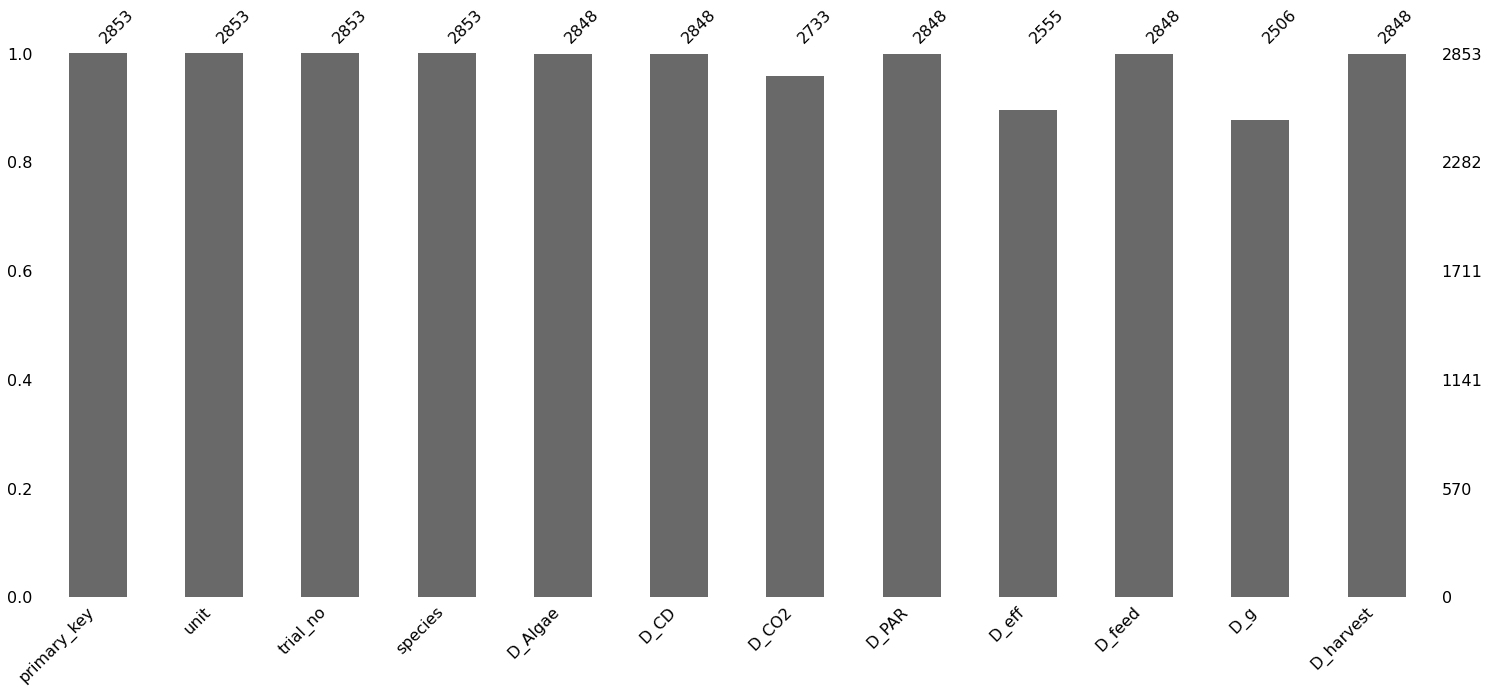

In [71]:
msno.bar(pbr_datamissing)

<AxesSubplot:>

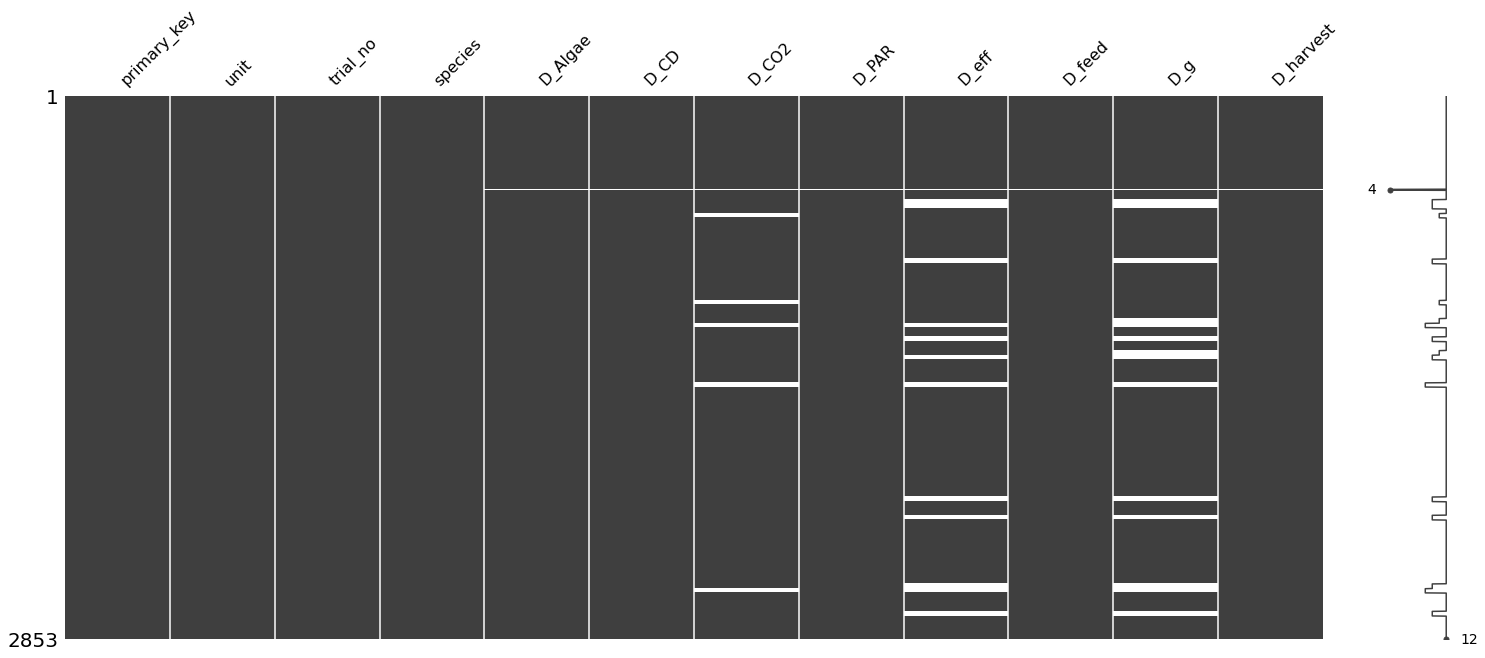

In [72]:
msno.matrix(pbr_datamissing)

<AxesSubplot:>

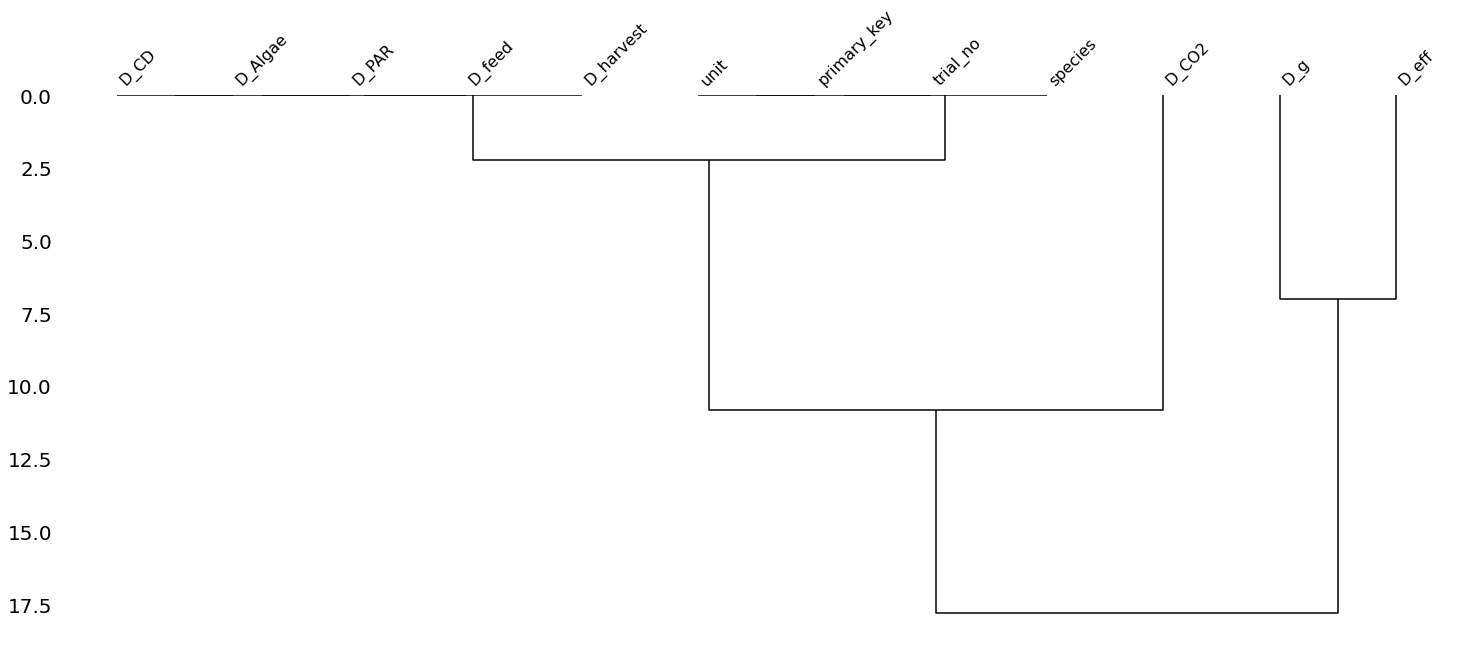

In [73]:
msno.dendrogram(pbr_datamissing)

<AxesSubplot:>

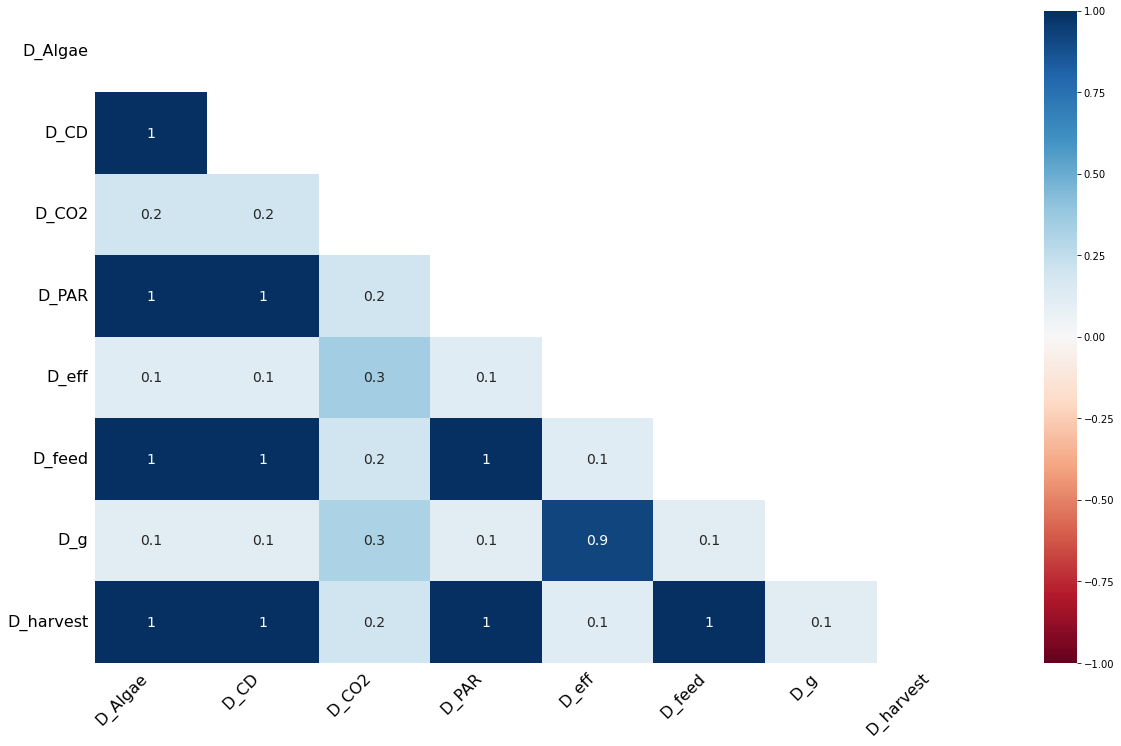

In [74]:
msno.heatmap(pbr_datamissing)

In [78]:
dataset = sum_hour_cleaned_indexed.copy()

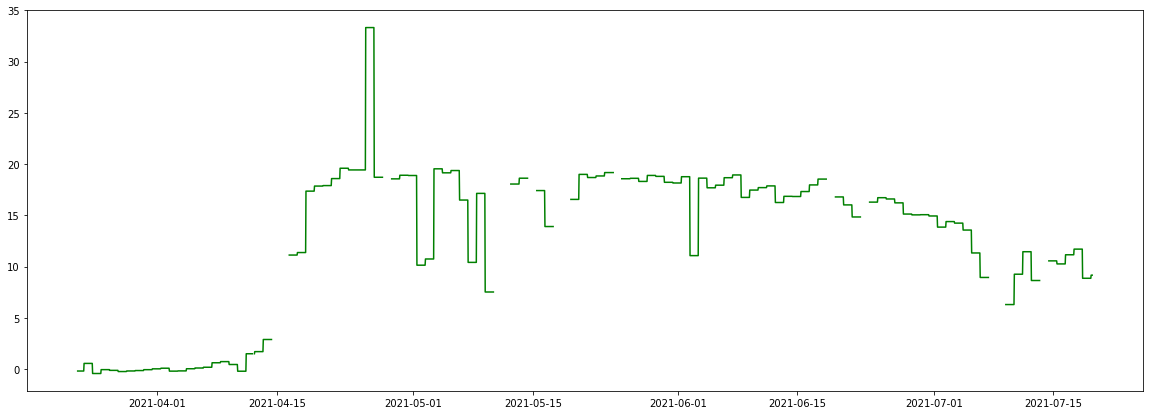

In [81]:
# set the size of our plot
plt.rcParams['figure.figsize']=(20,7)
# plots our series
plt.plot(dataset['D_g'], color='green')
# adds title to our time series plot
#plt.title('Customers visted shop since 1950') 
# print the plot
plt.show()


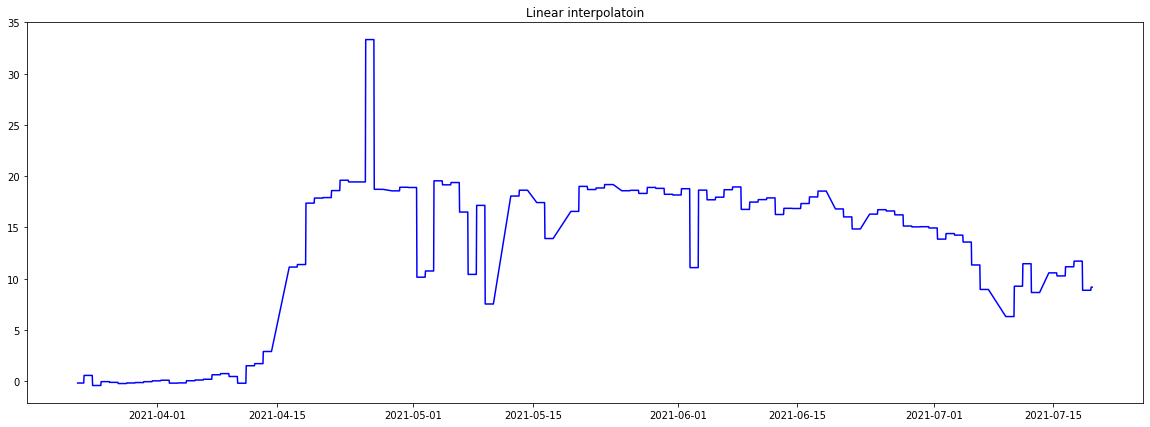

In [83]:
# setting the plot size
plt.rcParams['figure.figsize']=(20,7)
# on our data, impute the missing values using rolling window method
dataset['D_g_L']= dataset['D_g'].interpolate(method='linear')
# plot the complete dataset
plt.plot(dataset['D_g_L'], color='blue')
# add the tittle of our plot as Linear interpolation
plt.title('Linear interpolatoin')
# print the plot
plt.show()

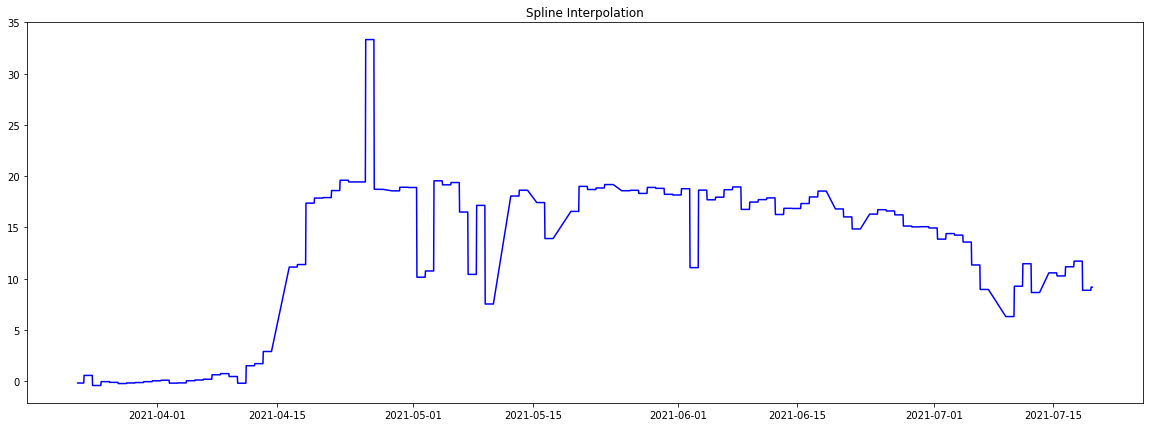

In [84]:
# setting the plot size
plt.rcParams['figure.figsize']=(20,7)
# on our data, impute the missing values using the interpolation techniques and specifically, the lineare method
dataset['D_g_Spline']= dataset['D_g'].interpolate(option='spline')
# plot the complete dataset
plt.plot(dataset['D_g_Spline'], color='blue')
# add the tittle of our plot as Linear interpolation
plt.title('Spline Interpolation')
# print the plot
plt.show()

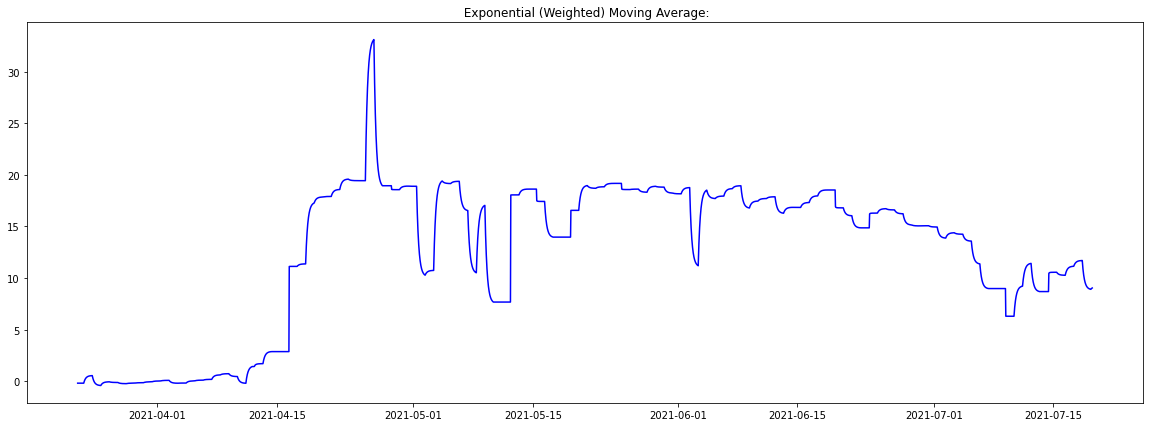

In [85]:
# ffigure size
plt.rcParams['figure.figsize']=(20,7)
# On the customer column of our data, impute the missing values with the LOCF
dataset['EWMA']= dataset['D_g'].ewm(halflife=4).mean()
# plot our time series with imputed values
plt.plot(dataset['EWMA'], color='blue')
#Plot tittle
plt.title(' Exponential (Weighted) Moving Average:')
# show the plot
plt.show()

In [90]:
null_cols = sum_hour_cleaned_indexed.columns[sum_hour_cleaned_indexed.isnull().any()].tolist()
null_cols

['D_Algae', 'D_CD', 'D_CO2', 'D_PAR', 'D_eff', 'D_feed', 'D_g', 'D_harvest']

In [91]:
for pbr_col in null_cols:
    sum_hour_cleaned_indexed[pbr_col]=sum_hour_cleaned_indexed[pbr_col].interpolate(option='spline')


In [93]:
sum_hour_cleaned_indexed.isna().sum()

primary_key    0
unit           0
trial_no       0
species        0
D_Algae        0
D_CD           0
D_CO2          0
D_PAR          0
D_eff          0
D_feed         0
D_g            0
D_harvest      0
dtype: int64

<AxesSubplot:>

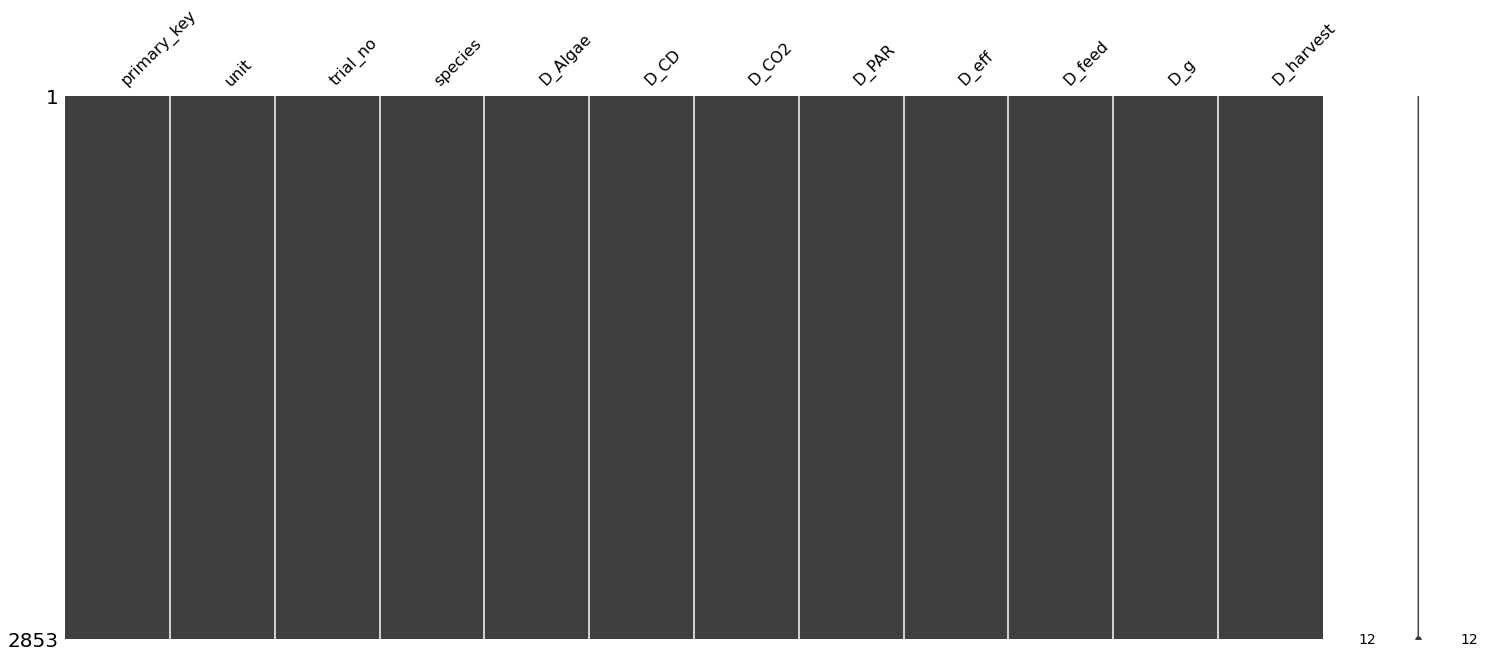

In [94]:
msno.matrix(sum_hour_cleaned_indexed)

In [95]:
sum_hour_cleaned_indexed = sum_hour_cleaned_indexed.reset_index(level=0)

In [96]:
sum_hour_cleaned_indexed.head()

,_timeString,primary_key,unit,trial_no,species,D_Algae,D_CD,D_CO2,D_PAR,D_eff,D_feed,D_g,D_harvest
0,2021-03-22 16:00:00,1616425200,5,10,7,0.0,-0.1074,0.0,0.0,0.0,0.0,-0.1895,0.0
1,2021-03-22 17:00:00,1616428800,5,10,7,0.0,-0.1074,0.0,0.0,0.0,0.0,-0.1895,0.0
2,2021-03-22 18:00:00,1616432400,5,10,7,0.0,-0.1074,0.0,0.0,0.0,0.0,-0.1895,0.0
3,2021-03-22 19:00:00,1616436000,5,10,7,0.0,-0.1074,0.0,0.0,0.0,0.0,-0.1895,0.0
4,2021-03-22 20:00:00,1616439600,5,10,7,0.0,-0.1074,0.0,0.0,0.0,0.0,-0.1895,0.0


In [97]:
new_col = list(sum_hour_cleaned.columns)
sum_hour_cleaned_indexed=sum_hour_cleaned_indexed[new_col]

In [98]:
sum_hour_cleaned_indexed.head()

,primary_key,_timeString,unit,trial_no,species,D_Algae,D_CD,D_CO2,D_PAR,D_eff,D_feed,D_g,D_harvest
0,1616425200,2021-03-22 16:00:00,5,10,7,0.0,-0.1074,0.0,0.0,0.0,0.0,-0.1895,0.0
1,1616428800,2021-03-22 17:00:00,5,10,7,0.0,-0.1074,0.0,0.0,0.0,0.0,-0.1895,0.0
2,1616432400,2021-03-22 18:00:00,5,10,7,0.0,-0.1074,0.0,0.0,0.0,0.0,-0.1895,0.0
3,1616436000,2021-03-22 19:00:00,5,10,7,0.0,-0.1074,0.0,0.0,0.0,0.0,-0.1895,0.0
4,1616439600,2021-03-22 20:00:00,5,10,7,0.0,-0.1074,0.0,0.0,0.0,0.0,-0.1895,0.0


In [99]:
sum_hour_cleaned_indexed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2853 entries, 0 to 2852
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   primary_key  2853 non-null   int64         
 1   _timeString  2853 non-null   datetime64[ns]
 2   unit         2853 non-null   int16         
 3   trial_no     2853 non-null   int64         
 4   species      2853 non-null   int64         
 5   D_Algae      2853 non-null   float32       
 6   D_CD         2853 non-null   float32       
 7   D_CO2        2853 non-null   float32       
 8   D_PAR        2853 non-null   float32       
 9   D_eff        2853 non-null   float32       
 10  D_feed       2853 non-null   float32       
 11  D_g          2853 non-null   float32       
 12  D_harvest    2853 non-null   float32       
dtypes: datetime64[ns](1), float32(8), int16(1), int64(3)
memory usage: 184.0 KB
